## Observations

Month is not a useful variable. Try Quarter.
Best result so far is decision tree with df[['Exterior Wall', 'Fixtures', 'Neighborhood', 'Story Height', 'Assessment Ratio', 'Building Grade', 'Quarter']]

Lots of outliers here, try RandomForest

With LightGBM, untuned, got to 33.7

## Next step: incorporate data from full dataframe.

Possibly: average fixtures per house in the neighborhood?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
%matplotlib inline
sns.set(style='darkgrid')

In [128]:
df1=pd.read_csv('nashville_20190827200234.csv', parse_dates = ['Most Recent Sale Date', 'Sale Date'], dtype={'Zone': str, 'Neighborhood': str})

/home/drew/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [129]:
#Correcting badly-entered data
df1.loc[176025, 'Sale Price'] = 37000
df1.loc[27056, 'Sale Price'] = 161000
df1.loc[191004, 'Sale Price'] = 810000
df1.loc[239278, 'Sale Price'] = 280395
df1.loc[138891, 'Sale Price'] = 200000
df1.loc[241961, 'Sale Date'] = '2019-03-04'
df1.loc[241961, 'Sale Date'] = pd.to_datetime(df1.loc[241961, 'Sale Date'])
df1.loc[241961, 'Sale Price'] = 370000
df1.loc[230115, 'Sale Price'] = 325000
df1.loc[53151, 'Sale Price'] = 310900
df1.loc[259815, 'Sale Price'] = 1513142
df1.loc[129682, 'Sale Price'] = 1300000
df1.loc[154271, 'Square Footage Improved'] = 10094
df1.drop(190142, inplace=True) #Has a massive ADU ~4 times the size of the 'main' structure. Main struct is low-grade, ADU is luxury.
df1.drop(128094, inplace=True) #Can't find out anything about this house. Improbably large sqft and acreage, low price.

In [130]:
#Creating new dataframe without duplicate entires
df=df1.sort_values(by='Sale Date').drop_duplicates(subset='Map & Parcel', keep = 'last')
#Dropping parcels that were involved in multi-parcel sales
#Want to create a new column which is the mean sale price per square foot of a parcel in that neighborhood
df['PPS']=df['Sale Price']/df['Square Footage Improved']
df['PPS']=df['PPS'].replace(np.inf, np.nan)
meanpps=df.groupby('Neighborhood')['PPS'].mean().to_frame().rename(columns={'PPS':'NeighborhoodPPS'})
df=df.merge(meanpps, how='left', left_on = 'Neighborhood',right_index=True)
df=df[df['Multiple Parcels Involved in Sale'] == 'No']
#Testing the averaged assessment ratio idea.
df['Assessment Ratio'] = df['Assessment Land Improved'] / df['Total Appraisal Value Improved']
nbhdratio=df.groupby('Neighborhood')['Assessment Ratio'].mean().to_frame().rename(columns={'Assessment Ratio':'Nbhd Ratio'})
df=df.merge(nbhdratio, how='left', left_on = 'Neighborhood',right_index=True)
df['Month']= df['Sale Date'].dt.month
df['Quarter'] = df['Sale Date'].dt.quarter
df['Year'] = df['Sale Date'].dt.year
#df = df[(df.Neighborhood != '9527') & (df.Neighborhood != '9026')]
df['Building Grade']= df['Building Grade'].str.replace(r'\w\w\w', '').dropna()
#Dropping a few outliers
df=df[df.Fixtures <=23]
df=df[df['Land Area Acres'] <=10]
df=df[df.PPS <= 1150]

In [131]:
TYPEDICT = {'HIGHRISE APT': 'HRISE', 'APARTMENT': 'CONDO', 'HRISE CONDO': 'HRISE',
            'RESD CONDO': 'CONDO', 'RW SING FAM': 'SINGLE FAM', 'SINGLE FAM': 'SINGLE FAM',
            'RZ SING FAM': 'SINGLE FAM', 'RH SING FAM': 'SINGLE FAM',
            'RY SING FAM': 'SINGLE FAM', 'MODULAR HOME': 'SINGLE FAM',
            'SING FAM': 'SINGLE FAM', 'RESD TRIPLEX': 'PLEX', 'RESD QUADPLX': 'PLEX',
            'R1 DUPLEX': 'PLEX', 'RES DUPLEX': 'PLEX', 'LODGE/FRAT\'L': 'THIRD',
            'CHURCH': 'THIRD', 'HEALTH CLUB': 'COMM', 'GROCERY/SMKT': 'COMM',
            'RETAIL/SHPG': 'COMM', 'DAYCARE': 'COMM', 'MARKET': 'COMM',
            'REST/BAR': 'COMM', 'OFFICE': 'COMM', 'WAREHOUSE': 'COMM',
            'EQUIP SHED': 'COMM', 'SERV GARAGE': 'COMM', 'TRUCK TERM': 'COMM',
            'ZERO LOT': 'VACANT', 'CAR WASH': 'COMM', 'MED OFC': 'COMM',
            'LAUNDRY': 'COMM', 'AUDITORIUM': 'THIRD', 'BANK': 'COMM', 'BOWLING': 'COMM',
            'BUSINESS CTR': 'COMM', 'CINEMA': 'COMM', 'CLUB/UNION': "THIRD",
            "COMM GRNHSE": "COMM", 'WHSE RETAIL': 'COMM', 'ENG/RESEARCH': 'COMM',
            'COUNTRY CLUB': 'THIRD', 'DEPT STORE': 'COMM', 'TENNIS': 'THIRD',
            'WALKUP APT': 'CONDO', 'DRUG STORE': 'COMM', 'DISC STORE': 'COMM',
            'ELDERLY HSG': 'CONDO', "FUNERAL HM": "THIRD", 'SALES SHOWRM': 'COMM',
            'LUMBER': 'COMM', 'MANF PLANT': 'COMM', 'MAINT HANGER': 'COMM',
            'MOTEL': 'COMM', 'MINI-LUBE': 'COMM', 'MINI-WAREHSE': 'COMM',
            'FAST FOOD': 'COMM', 'HOTEL': 'COMM', 'NURSING HOME': 'CONDO', "PARK'G GAR": 'COMM',
            'SERV STATION': 'COMM', 'INDOOR WP': 'COMM', 'HOSPITAL': 'THIRD', 'T-HANGER': 'COMM'
            }

df['Building Type Custom']=df['Building Type'].map(lambda x: TYPEDICT[x] if (x != '' and not pd.isnull(x)) else None)

In [134]:
df['Log Assessment']= df['Assessment Land Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log Assessment']=df['Log Assessment'].replace(np.inf, np.nan)
df['Log Fixtures']= df['Fixtures'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log Fixtures']=df['Log Fixtures'].replace(np.inf, np.nan)
df['Log SqFt']= df['Square Footage Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log SqFt']=df['Log SqFt'].replace(np.inf, np.nan)
df['Log PPS']= df['PPS'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log PPS']=df['Log PPS'].replace(np.inf, np.nan)
df['Log Land']= df['Land Area Acres'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df.Quarter= df.Quarter.map(lambda x: str(x) if pd.notnull(x) else '')
df.Year= df.Year.map(lambda x: str(x) if pd.notnull(x) else '')

In [8]:
df.nsmallest(5, 'PPS')[['Location', 'Zone', 'Sale Price', 'PPS', 'Square Footage Improved', 'Building Type Custom', 'Building Condition']]

,Location,Zone,Sale Price,PPS,Square Footage Improved,Building Type Custom,Building Condition
117379,31 N HILL ST,1,10001.0,4.857212,2059.0,SINGLE FAM,Average
87022,5801 MACKIE PL,3,10000.0,6.635700,1507.0,SINGLE FAM,Average
266262,6582 SUNNYWOOD DR,1,15000.0,6.934813,2163.0,SINGLE FAM,Average
210028,4839 JONQUIL DR,1,30000.0,7.812500,3840.0,SINGLE FAM,Average
244774,909 MULBERRY HILL PL,8,28000.0,8.158508,3432.0,SINGLE FAM,Average


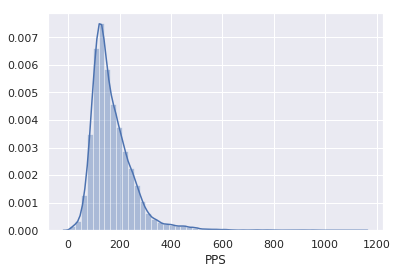

In [8]:
sns.distplot(df['PPS'].dropna())

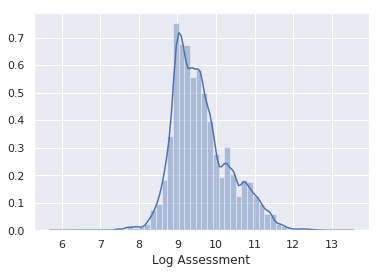

In [135]:
# df['Log Assessment']= df['Land Value Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
# df['Log Assessment']=df['Log Assessment'].replace(np.inf, np.nan)
sns.distplot(df['Log Assessment'].dropna())

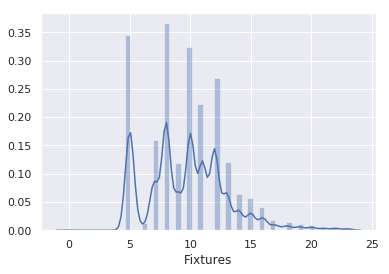

In [153]:
sns.distplot(df['Fixtures'].dropna())

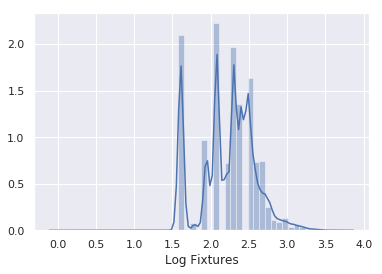

In [143]:
df['Log Fixtures']= df['Fixtures'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log Fixtures']=df['Log Fixtures'].replace(np.inf, np.nan)
sns.distplot(df['Log Fixtures'].dropna())

In [10]:
df.nlargest(10, 'Land Area Acres')

,Assessment Classification*,Assessment Improvement,Assessment Land,Assessment Total,Assessment Year,Baths,Beds2,Building Condition,Building Condition2,Building Grade,...,Assessment Ratio,Nbhd Ratio,Month,Quarter,Year,Log Assessment,Log Fixtures,Log SqFt,Log PPS,Log Land
206093,RES,"$54,825","$28,825","$83,650",2019.0,2.0,NaN,Average,NaN,C,...,0.086148,0.047750,7,3,2015,10.268998,2.079442,7.557995,5.163891,2.302585
5002,RES,"$101,950","$27,200","$129,150",2019.0,4.0,NaN,Average,NaN,B,...,0.052652,0.068667,2,1,2017,10.210972,2.772589,7.986165,5.166334,2.291524
1511,RES,"$70,625","$22,525","$93,150",2019.0,4.0,NaN,Average,NaN,A,...,0.060454,0.056145,2,1,2019,10.022381,2.833213,8.091627,5.194554,2.260721
201393,RES,"$35,625","$40,750","$76,375",2019.0,3.0,NaN,Average,NaN,C,...,0.133388,0.138705,5,2,2016,10.615211,2.397895,7.716906,4.874429,2.230014
1513,RES,"$93,275","$19,725","$113,000",2019.0,5.0,NaN,Average,NaN,B,...,0.043639,0.056145,5,2,2016,9.889642,2.890372,8.493310,4.489791,2.218116
1512,RES,"$86,800","$17,000","$103,800",2019.0,3.0,NaN,Average,NaN,B,...,0.040944,0.056145,12,4,2017,9.740969,2.397895,8.029107,5.113059,2.193886
149664,RES,"$713,575","$611,100","$1,324,675",2019.0,7.0,NaN,Average,NaN,X,...,0.115330,0.136330,11,4,2016,13.323016,3.044522,9.417517,6.056222,2.186051
1516,RES,"$46,825","$21,850","$68,675",2019.0,2.0,NaN,Average,NaN,B,...,0.079541,0.056145,11,4,2017,9.991956,2.079442,7.726654,5.153638,2.169054
169807,RES,"$25,600","$315,200","$340,800",2019.0,2.0,1.0,Average,Average,C,...,0.231221,0.129040,3,1,2018,12.660963,2.079442,7.638198,6.513785,2.140066
8193,RURAL,"$80,700","$32,250","$112,950",2019.0,3.0,NaN,Average,NaN,C,...,0.071381,0.073556,12,4,2017,10.381273,2.484907,8.166500,4.705220,2.130610


In [142]:
df.nlargest(10,'Fixtures')[['Fixtures', 'PPS']]

,Fixtures,PPS
135837,23.0,147.446655
128812,23.0,395.711003
131925,23.0,348.742903
146599,23.0,142.178087
148612,23.0,72.033135
128717,23.0,301.935183
236052,23.0,199.430199
261730,23.0,64.534772
130400,23.0,117.342040
190873,23.0,104.370026


In [12]:
np.std(df.PPS)

82.81928563630228

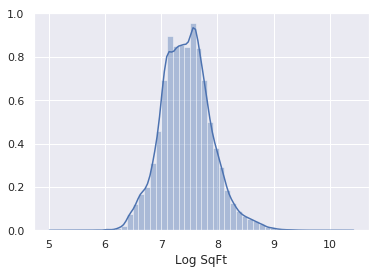

In [147]:
df['Log SqFt']= df['Square Footage Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log SqFt']=df['Log SqFt'].replace(np.inf, np.nan)
sns.distplot(df['Log SqFt'].dropna())

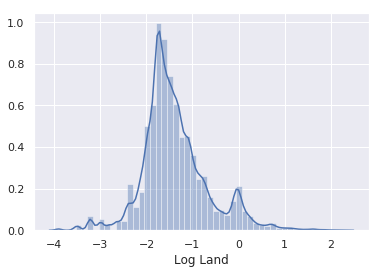

In [14]:
df['Log Land']= df['Land Area Acres'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
sns.distplot(df['Log Land'].dropna())

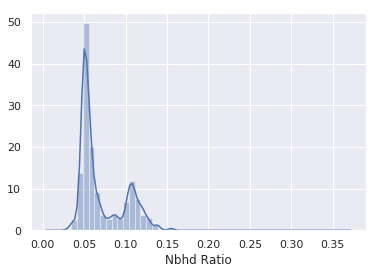

In [60]:
sns.distplot(df['Nbhd Ratio'].dropna())

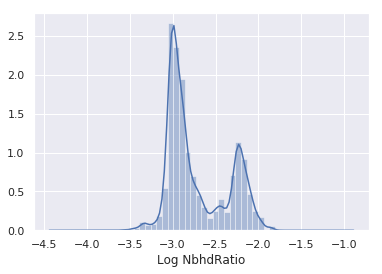

In [156]:
df['Log NbhdRatio']= df['Nbhd Ratio'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log NbhdRatio']=df['Log NbhdRatio'].replace(np.inf, np.nan)
sns.distplot(df['Log NbhdRatio'].dropna())

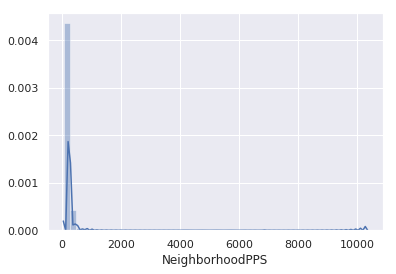

In [188]:
sns.distplot(df['NeighborhoodPPS'].dropna())

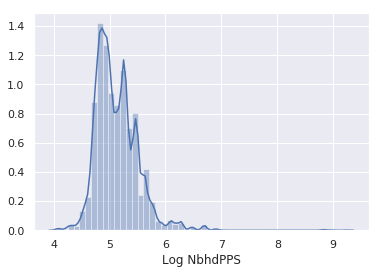

In [157]:
df['Log NbhdPPS']= df['NeighborhoodPPS'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log NbhdPPS']=df['Log NbhdPPS'].replace(np.inf, np.nan)
sns.distplot(df['Log NbhdPPS'].dropna())

In [85]:
df['Building Condition'].value_counts()

Average        52973
Fair             590
Good             242
Poor              85
Very Good         40
Very Poor         28
Dilapidated       16
Excellent         11
Name: Building Condition, dtype: int64

In [113]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import median_absolute_error as MAE
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [174]:
df2 = df[['Log NbhdRatio','Building Condition','Log SqFt','Log Fixtures','Building Type Custom','Building Grade','Year','Log NbhdPPS', 'PPS', 'Quarter', 'Log Assessment', 'Year Built']]
df2=df2.dropna()

In [206]:
X= pd.get_dummies(df2[['Log NbhdRatio','Year','Year Built','Log NbhdPPS','Log Assessment','Building Condition','Log Fixtures','Building Grade','Building Type Custom','Log SqFt', 'Quarter']])
y=df2['PPS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=42)

In [201]:
print(df.shape)
print(df2.shape)

(53985, 80)
(53908, 12)


In [207]:
from sklearn.dummy import DummyRegressor as DR
model = DR(strategy='median')
dr=model.fit(X_train, y_train)
y_pred= dr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)
print(MSE(y_pred, y_test)**0.5)

84.94622655186863


In [208]:
model = DTR()
dtr=model.fit(X_train, y_train)
y_pred= dtr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)
print(MSE(y_pred, y_test)**0.5)

42.27872016981829


In [209]:
from sklearn.ensemble import RandomForestRegressor as RFR
model = RFR(random_state=42)
rfr=model.fit(X_train,y_train)
y_pred=rfr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)
print(MSE(y_pred, y_test)**0.5)

/home/drew/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


32.20714631946678


In [210]:
from xgboost import XGBRegressor as XGBR
#Best model parameters from GridSearchCV
model = XGBR(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4, gamma=0,
       importance_type='gain', learning_rate=0.08, max_delta_step=0,
       max_depth=6, min_child_weight=1.5, missing=None, n_estimators=600,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
       silent=None, subsample=0.6, verbosity=1)

xgbr=model.fit(X_train,y_train)
y_predxg=xgbr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)
print(MSE(y_predxg, y_test)**0.5)
print(MAE(y_predxg,y_test))

/home/drew/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:04:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
29.23682744706676
11.065112444637094


<Figure size 648x648 with 0 Axes>

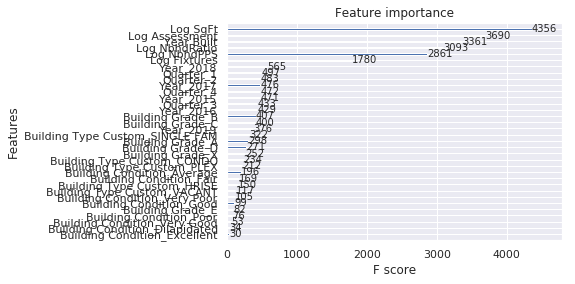

In [211]:
import xgboost as xgb
plt.figure(figsize=(9,9))
xgb.plot_importance(model)

In [30]:
from sklearn.model_selection import GridSearchCV
params={'learning_rate':[.07,.08,.09]}
rfgrid = GridSearchCV(estimator = xgbr,param_grid=params, cv = 5, verbose=2, n_jobs = -1)
rfgrid.fit(X, y)

In [33]:
print(MSE(y_test, rfgrid.best_estimator_.predict(X_test))**0.5) 
print(MAE(y_test, rfgrid.best_estimator_.predict(X_test)))
print(rfgrid.best_estimator_)

In [212]:
gbm = lgb.LGBMRegressor(num_leaves=80,
                        learning_rate=0.25,
                        n_estimators=325)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l2',
        early_stopping_rounds=3)
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

[1]	valid_0's l2: 4507.97	valid_0's l2: 4507.97
Training until validation scores don't improve for 3 rounds.
[2]	valid_0's l2: 3164.29	valid_0's l2: 3164.29
[3]	valid_0's l2: 2376.06	valid_0's l2: 2376.06
[4]	valid_0's l2: 1911.86	valid_0's l2: 1911.86
[5]	valid_0's l2: 1628.7	valid_0's l2: 1628.7
[6]	valid_0's l2: 1444.81	valid_0's l2: 1444.81
[7]	valid_0's l2: 1319.89	valid_0's l2: 1319.89
[8]	valid_0's l2: 1239.53	valid_0's l2: 1239.53
[9]	valid_0's l2: 1181.96	valid_0's l2: 1181.96
[10]	valid_0's l2: 1138.98	valid_0's l2: 1138.98
[11]	valid_0's l2: 1102.58	valid_0's l2: 1102.58
[12]	valid_0's l2: 1074.14	valid_0's l2: 1074.14
[13]	valid_0's l2: 1047.79	valid_0's l2: 1047.79
[14]	valid_0's l2: 1031.76	valid_0's l2: 1031.76
[15]	valid_0's l2: 1015.34	valid_0's l2: 1015.34
[16]	valid_0's l2: 1002.37	valid_0's l2: 1002.37
[17]	valid_0's l2: 992.522	valid_0's l2: 992.522
[18]	valid_0's l2: 980.665	valid_0's l2: 980.665
[19]	valid_0's l2: 970.751	valid_0's l2: 970.751
[20]	valid_0's l2: 

In [180]:
np.sqrt(901.112)

30.01852761212648

In [103]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import median_absolute_error as MAE
estimator = lgb.LGBMRegressor()
param_grid = {
    'learning_rate': [0.18,0.21],
    'n_estimators': [300,500],
    'min_child_weight':[3,4],
    'max_depth': [5]
}
params={}
gbm = GridSearchCV(estimator, param_grid, cv=5, scoring ='neg_mean_squared_error')
gbm.fit(X_train, y_train)
y_pred= gbm.predict(X_test)
print('Best parameters found by grid search are:', gbm.best_params_)
print(gbm.best_score_)
print(MSE(y_pred,y_test)**0.5)
print(MAE(y_pred,y_test))

Best parameters found by grid search are: {'learning_rate': 0.18, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 500}
-881.8307356522524
29.54707728069196
10.806907694402788


In [214]:
gbm.best_estimator_

In [28]:
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(gbm, y_train, y_test, cv=5)

## Examining where it went wrong

In [144]:
copiedxg= X_test.copy()
copiedxg['Actual']= y_test
copiedxg['Predicted']= y_predxg
copiedxg['Residual'] = np.absolute(copiedxg['Actual'] - copiedxg['Predicted'])

In [106]:
df.loc[235871]

In [151]:
#The pattern in my biggest flubs is, there's a big difference between the NeighborhoodPPS and the acutal PPS
#However, adding NeighborhoodPPS to the model significantly increases performance.
#So how can I tune it to accept NeighborhoodPPS while minimizing this error?
copiedxg.nlargest(20,'Residual')[['Log NbhdPPS', 'Actual', 'Predicted', 'Residual']]

,Log NbhdPPS,Actual,Predicted,Residual
235871,6.261019,971.843778,379.422028,592.421751
21634,4.981066,670.391061,89.252357,581.138704
110153,5.478194,723.981900,191.183151,532.798749
174722,5.026542,617.870722,200.512527,417.358195
144762,5.071907,588.505747,178.486832,410.018915
116778,5.622840,645.994832,336.024689,309.970143
91666,5.321845,729.361702,433.220825,296.140877
279614,6.675857,1115.859449,851.748108,264.111341
95765,8.938265,218.253968,474.134979,255.881011
149566,5.627625,558.243394,312.166656,246.076738


In [185]:
copied= X_test.copy()
copied['Actual']= y_test
copied['Predicted']= y_pred
copied['Residual'] = np.absolute(copied['Actual'] - copied['Predicted'])

In [186]:
copied.nlargest(20, 'Residual')[['Actual','Predicted','Residual', 'Log NbhdPPS']]

,Actual,Predicted,Residual,Log NbhdPPS
235871,971.843778,360.136794,611.706984,6.261019
110153,723.981900,203.798565,520.183336,5.478194
174722,617.870722,169.595437,448.275285,5.026542
91666,729.361702,302.874096,426.487606,5.321845
144762,588.505747,196.055064,392.450683,5.071907
279614,1115.859449,780.208628,335.650821,6.675857
45773,506.072874,187.619224,318.453651,5.367912
45775,416.666667,153.102313,263.564354,5.367912
116250,181.818182,434.791157,252.972976,5.745289
261255,1091.422702,852.546135,238.876567,6.285591


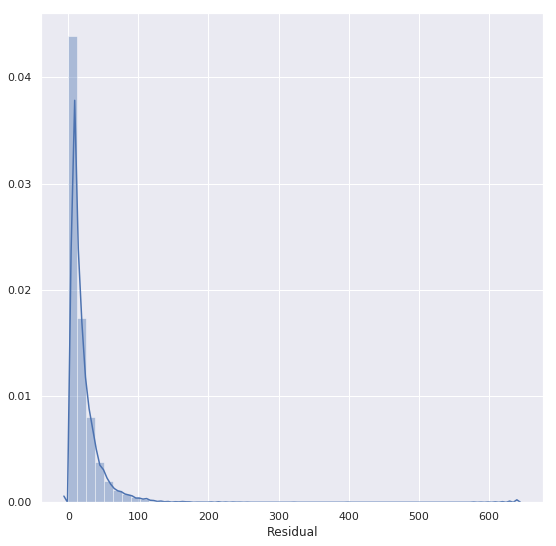

In [183]:
plt.figure(figsize=(9,9))
sns.distplot(copied.Residual.dropna())

In [110]:
df.loc[235871]

Assessment Classification*                                                RES
Assessment Improvement                                               $67,275 
Assessment Land                                                      $16,250 
Assessment Total                                                     $83,525 
Assessment Year                                                          2019
Baths                                                                       1
Beds2                                                                     NaN
Building Condition                                                    Average
Building Condition2                                                       NaN
Building Grade                                                              B
Building Grade2                                                           NaN
Building Type                                                      RESD CONDO
Building Type2                                                  

In [189]:
df.nsmallest(15, 'PPS')[['Sale Price', 'Location', 'PPS', 'Square Footage Improved', 'Log Land']]

,Sale Price,Location,PPS,Square Footage Improved,Log Land
117379,10001.0,31 N HILL ST,4.857212,2059.0,-2.302585
87022,10000.0,5801 MACKIE PL,6.635700,1507.0,-2.040221
266262,15000.0,6582 SUNNYWOOD DR,6.934813,2163.0,-1.347074
210028,30000.0,4839 JONQUIL DR,7.812500,3840.0,-0.733969
244774,28000.0,909 MULBERRY HILL PL,8.158508,3432.0,-1.660731
158357,9000.0,270 TAMPA DR Unit E-1,8.211679,1096.0,NaN
241964,25500.0,3707 EZELL RD,8.799172,2898.0,-0.713350
231682,13700.0,800 POINT BREAK CIR S,9.060847,1512.0,-1.609438
182809,17500.0,2817 CREEKVIEW DR,9.157509,1911.0,-1.386294
161373,14000.0,4000 ANDERSON RD Unit 76,9.459459,1480.0,NaN
